### Exercise 9.1
As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as the sample size decreases? What is the smallest sample size that yields a positive test?

In [1]:
import first
import hypothesis
import scatter
import thinkstats2
import random
import thinkplot

import numpy as np

In [2]:
def RunResampleTest(firsts, others):
    """Tests differences in means by resampling.

    firsts: DataFrame
    others: DataFrame
    """
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansResample(data)
    p_value = ht.PValue(iters=10000)
    print('\nmeans permute preglength')
    print('p-value =', p_value)
    print('actual =', ht.actual)
    print('ts max =', ht.MaxTestStat())

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = hypothesis.DiffMeansPermute(data)
    p_value = ht.PValue(iters=10000)
    print('\nmeans permute birthweight')
    print('p-value =', p_value)
    print('actual =', ht.actual)
    print('ts max =', ht.MaxTestStat())

In [3]:
class DiffMeansResample(hypothesis.DiffMeansPermute):
    """Tests a difference in means using resampling."""
    
    def RunModel(self):
        
        group1 = np.random.choice(self.pool, self.n, replace=True)
        group2 = np.random.choice(self.pool, self.m, replace=True)
        return group1, group2

In [4]:
thinkstats2.RandomSeed(18)

live, firsts, others = first.MakeFrames()
#RunResampleTest(firsts, others)

In [5]:
def Resample(xs):
    return np.random.choice(xs, len(xs), replace=True)

def FalseNegRate(data, num_runs=100):
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)

        ht = hypothesis.DiffMeansPermute((sample1, sample2))
        pvalue = ht.PValue(iters=101)
        if pvalue > 0.05:
            count += 1

    return count / num_runs

In [6]:
# calculate p-value for difference in mean, every round reduce the sample size by half. 
count = 0
n=len(live)
while (count < 12):
    count =count + 1
    sample = thinkstats2.SampleRows(live, n)

    firsts = sample[sample.birthord == 1]
    others = sample[sample.birthord != 1]
    iters =1000
    data = (firsts.totalwgt_lb.dropna().values, others.totalwgt_lb.dropna().values)
    ht = hypothesis.DiffMeansPermute(data)
    p = ht.PValue(iters=iters)
    print( 'round' , count, ': sample size is', n, ', p-value for difference in baby weight mean is' ':', p)
    
    neg_rate = FalseNegRate(data)
    print('\t power is', round(1-neg_rate,4))
    print('\n')
    n //= 2

round 1 : sample size is 9148 , p-value for difference in baby weight mean is: 0.0
	 power is 1.0


round 2 : sample size is 4574 , p-value for difference in baby weight mean is: 0.005
	 power is 0.79


round 3 : sample size is 2287 , p-value for difference in baby weight mean is: 0.001
	 power is 0.95


round 4 : sample size is 1143 , p-value for difference in baby weight mean is: 0.178
	 power is 0.29


round 5 : sample size is 571 , p-value for difference in baby weight mean is: 0.633
	 power is 0.05


round 6 : sample size is 285 , p-value for difference in baby weight mean is: 0.827
	 power is 0.06


round 7 : sample size is 142 , p-value for difference in baby weight mean is: 0.138
	 power is 0.29


round 8 : sample size is 71 , p-value for difference in baby weight mean is: 0.733
	 power is 0.08


round 9 : sample size is 35 , p-value for difference in baby weight mean is: 0.649
	 power is 0.08


round 10 : sample size is 17 , p-value for difference in baby weight mean is: 0.3
	

#### Conclusion
##### as sampel size decrease, the p-value increase, though not constantly. At the same time, power decreases. Once sample size is at or less than 1143, the P-value is more than 7%, so it is no longer sattistically signicant. it is also underpowered. 

### Exercise 10.1:
1. Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. 
2. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Read the BRFSS data and extract heights and log weights.

In [3]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [4]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [6]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)
    print(meanx)
    
    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx
        
    return inter, slope

inter, slope = LeastSquares(heights, log_weights)
inter, slope

168.95618848400332


(0.9930804163932829, 0.005281454169417805)

The following function evaluates the fitted line at the given xs.

In [8]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

Make a scatter plot of the data and show the fitted line.

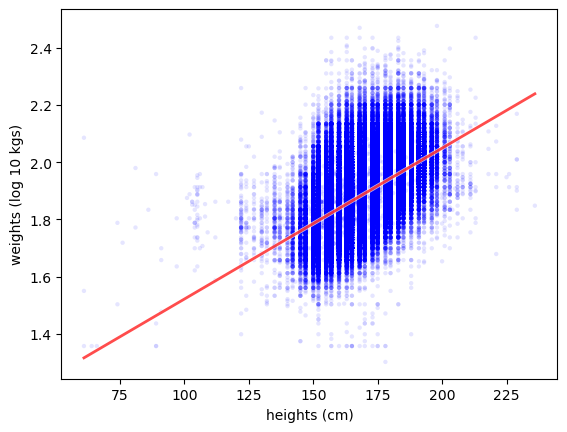

In [9]:
fit_xs, fit_ys = FitLine(heights, inter, slope)

thinkplot.Scatter(heights, log_weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="heights (cm)", ylabel='weights (log 10 kgs)', legend=False)

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

168.95618848400332


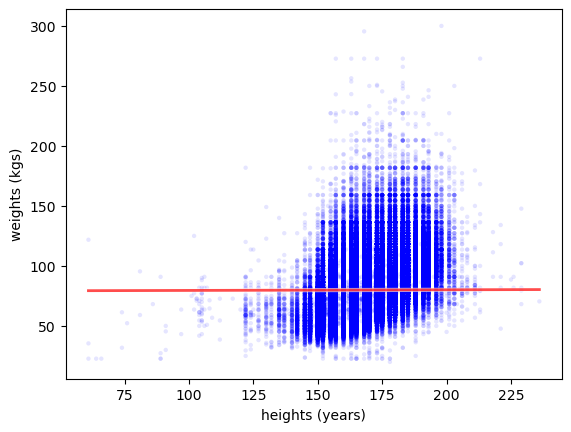

In [14]:
inter2, slope2 = LeastSquares(heights, weights)
#adjust the intercept by adding mean of heights
inter2 = inter2 +slope2*168.96

fit_xs, fit_ys = FitLine(heights, inter2, slope)

thinkplot.Scatter(heights, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="heights (years)", ylabel='weights (kgs)', legend=False)

Plot percentiles of the residuals.

In [16]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

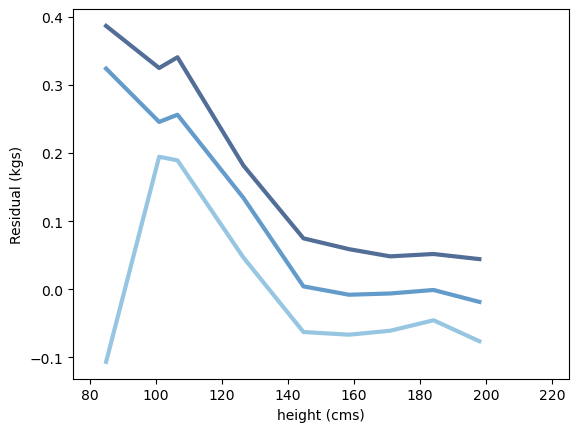

In [17]:
df['residual'] = Residuals(heights, log_weights, inter, slope)

bins = np.arange(75, 225, 15)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

height_means = [group.htm3.mean() for _, group in groups][1:-1]
#height_means

cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

def PlotPercentiles(height_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(height_means, weight_percentiles, label=label)
        
PlotPercentiles(height_means, cdfs)

thinkplot.Config(xlabel="height (cms)",
                 ylabel='Residual (kgs)',
                 xlim=[75, 225])        

Compute correlation.

In [18]:
corr = thinkstats2.Corr(heights, weights)
print('The correlation between hights and log-weights is', corr)

The correlation between hights and log-weights is 0.5087364789734607


Compute coefficient of determination.

In [20]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

inter, slope = LeastSquares(heights, weights)
res = Residuals(heights, weights, inter, slope)
r2 = CoefDetermination(weights, res)
print('the coefficient of determination r2 is', round(r2, 4))

168.95618848400332
the coefficient of determination r2 is 0.2588


Confirm that  𝑅2=𝜌2.

In [21]:
p = round(corr**2, 4)
print('it is', p==round(r2,4), ' that R2 is same as 𝜌2 ')

it is True  that R2 is same as 𝜌2 


1. Compute Std(ys), which is the RMSE of predictions that don't use height.
2. Compute Std(res), the RMSE of predictions that do use height.
3. How much does height information reduce RMSE?

In [23]:
print('RSME without height: is', Std(weights))
print('RSME with height is', Std(res))
print('reduction is: ', round((Std(weights)-Std(res))/Std(weights)*100, 2), '%')

RSME without height: is 19.5478653561752
RSME with height is 16.82919306997716
reduction is:  13.91 %


Use resampling to compute sampling distributions for inter and slope.

In [25]:
sample = thinkstats2.SampleRows(df, len(df))
#sample

Plot the sampling distribution of slope.

In [28]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

168.94030043048565
168.95075688676005
168.94817498332625
168.96621041249824
168.98541552982073
168.98404878837488
168.95890175630066
168.93958548070898
168.9581590169567
168.9385648456921
168.95004951595627
168.97559823359404
168.9345151478405
168.9747771781968
168.9533918430041
168.9515450999414
168.96970179267973
168.90918116776814
168.93839810828837
168.9993785242224
168.96795104994038
168.97119990298916
168.9320494553245
168.96697841508518
168.94626508215606
168.92906334000284
168.9594373370521
168.95615311546314
168.9751207583015
168.95646132702763
168.9297378685907
168.9596975484549
168.93490925443118
168.96935063360215
168.95398047656582
168.95078467632734
168.95472574223407
168.97156116736394
168.97336496291356
168.97497423149215
168.95838638614362
168.95035772752075
168.9414398027446
168.96513925099538
168.97014895208068
168.94909203904686
168.98875027789566
168.9458457123224
168.966596940116
168.95896491440814


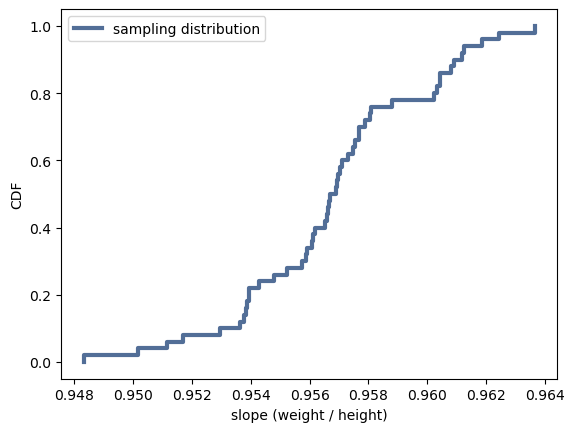

In [29]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        heights = sample.htm3
        weights = sample.wtkg2
        estimates = LeastSquares(heights, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

inters, slopes = SamplingDistributions(sample, iters=50)

sampling_cdf = thinkstats2.Cdf(slopes)

thinkplot.Cdf(sampling_cdf, label='sampling distribution')

thinkplot.Config(xlabel='slope (weight / height)',
                   ylabel='CDF',
                   legend=True, loc='upper left')

1. Compute the p-value of the slope.
2. Compute the 90% confidence interval of slope.
3. Compute the mean of the sampling distribution.
4. Compute the standard deviation of the sampling distribution, which is the standard error.

In [31]:
pvalue = sampling_cdf[0]
print('pvalue is', pvalue)

ci = sampling_cdf.Percentile(5), sampling_cdf.Percentile(95)
print('90% confidence interval are', round(ci[0],2), 'to', round (ci[1],2))

print('slope mean is',thinkstats2.Mean(slopes))

print('slope std deviation is', thinkstats2.Std(slopes, mu=None))

pvalue is 0
90% confidence interval are 0.95 to 0.96
slope mean is 0.9567905294382182
slope std deviation is 0.003152034041209103


resample rows '*without*' weights, compute mean height, and summarize results.

In [32]:
#call the resample function
def ResampleRowsWeighteds(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [34]:
#call summarize function
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [35]:
sample2 = thinkstats2.ResampleRows(df)

heights = sample2.htm3

print('mean height is:',thinkstats2.Mean(heights))
Summarize(heights)

mean height is: 168.95856070252026
mean, SE, CI 168.95856070252026 10.404675339488355 (152.0, 185.0)


Resample rows '*with*' weights. Note that the weight column in this dataset is called finalwt.

In [41]:
weights = df['finalwt']
cdf = thinkstats2.Cdf(dict(weights))
indices = cdf.Sample(len(weights))
sample3 = df.loc[indices]

height3 = sample3.htm3

Summarize(height3)

mean, SE, CI 170.49537177388387 10.690585163156886 (155.0, 188.0)


#### Conclusion:
##### without weight, the mean height is 169cm, with weight, mean of sample height is 170cm. the difference is 2cm, about 0.5% difference. it is within std deviation range. I would conclude weight is an not an impotant factor when estimate height. 